In [ ]:
import sys
!{sys.executable} -m pip install seaborn

In [17]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)

In [122]:
def result_analysis(local, gt, static_part, file_name):
    local = local[['x','y','timestamp']].drop_duplicates().reset_index(drop=True)
    gt = gt[['x','y','timestamp']].drop_duplicates()

    local_static = local.iloc[:static_part*4]
    gt_static = gt.iloc[:static_part]

    local_moving = local.iloc[static_part*4:].reset_index(drop=True)
    gt_moving = gt.iloc[static_part:].reset_index(drop=True)


    static_results = []

    for i in range(static_part):

        gt_x, gt_y = gt_static.iloc[i][['x', 'y']]

        preds = local_static.iloc[i * 4:(i + 1) * 4][['x', 'y']].to_numpy()

        errors = np.sqrt((preds[:, 0] - gt_x)**2 + (preds[:, 1] - gt_y)**2)
        rmse = np.sqrt(np.mean(errors**2))

        pairwise_dists = [np.linalg.norm(a - b) for a, b in combinations(preds, 2)]
        mean_dispersion = np.mean(pairwise_dists)

        static_results.append({
            'Point #': i + 1,
            'GT (x, y)': f"({gt_x:.2f}, {gt_y:.2f})",
            'RMSE to GT': round(rmse, 3),
            'Mean Pairwise Distance': round(mean_dispersion, 3)
        })

    df_static_summary = pd.DataFrame(static_results)

    avg_row = {
        'Point #': 'Avg',
        'GT (x, y)': '',
        'RMSE to GT': round(df_static_summary['RMSE to GT'].mean(), 3),
        'Mean Pairwise Distance': round(df_static_summary['Mean Pairwise Distance'].mean(), 3)
    }
    df_static_summary.loc[len(df_static_summary)] = avg_row

    df_static_summary.to_csv(file_name, index=False)
    print("--static points analysis--")
    print(df_static_summary)
    print()

    moving_errors = np.sqrt((local_moving['x'] - gt_moving['x'])**2 +
                            (local_moving['y'] - gt_moving['y'])**2)

    rmse_moving = np.sqrt(np.mean(moving_errors**2))

    print(f"\n▶ Moving Part RMSE: {round(rmse_moving, 3)}")

In [28]:
df = pd.read_csv("1stFloor_ver2_wardriving.csv")

bssid_counts = df.groupby(['x', 'y', 'timestamp'])['BSSID'].nunique().reset_index(name='bssid_count')

bssid_count_std = bssid_counts.groupby(['x', 'y'])['bssid_count'].std().reset_index(name='bssid_count_std')

rssi_std_xy_bssid = df.groupby(['x', 'y', 'BSSID'])['RSSI'].std().reset_index()

rssi_std_xy = rssi_std_xy_bssid.groupby(['x', 'y'])['RSSI'].mean().reset_index(name='rssi_std')

grouped = df.groupby(['x', 'y'])
bssid_sets = {coord: set(g['BSSID']) for coord, g in grouped}
coords = list(bssid_sets.keys())

bssid_overlap_results = []
for c1, c2 in combinations(coords, 2):
    set1, set2 = bssid_sets[c1], bssid_sets[c2]
    inter = len(set1 & set2)
    union = len(set1 | set2)
    jaccard = inter / union if union > 0 else 0
    bssid_overlap_results.append({
        'coord1': c1,
        'coord2': c2,
        'BSSID_jaccard': jaccard
    })
bssid_overlap_df = pd.DataFrame(bssid_overlap_results)

mean_rssi = df.groupby(['x', 'y', 'BSSID'])['RSSI'].mean().reset_index()

rssi_diff_results = []
for c1, c2 in combinations(coords, 2):
    rssi1 = mean_rssi[(mean_rssi['x'] == c1[0]) & (mean_rssi['y'] == c1[1])]
    rssi2 = mean_rssi[(mean_rssi['x'] == c2[0]) & (mean_rssi['y'] == c2[1])]
    
    common = set(rssi1['BSSID']) & set(rssi2['BSSID'])
    if not common:
        continue
    
    diffs = []
    for bssid in common:
        r1 = rssi1[rssi1['BSSID'] == bssid]['RSSI'].values[0]
        r2 = rssi2[rssi2['BSSID'] == bssid]['RSSI'].values[0]
        diffs.append(abs(r1 - r2))
    
    rssi_diff_results.append({
        'coord1': c1,
        'coord2': c2,
        'avg_rssi_diff': np.mean(diffs),
        'common_bssid_count': len(common)
    })

rssi_diff_df = pd.DataFrame(rssi_diff_results)

mean_bssid_std_same_xy = bssid_count_std['bssid_count_std'].mean()
mean_rssi_std_same_xy = rssi_std_xy['rssi_std'].mean()

mean_jaccard_diff_xy = bssid_overlap_df['BSSID_jaccard'].mean()
mean_rssi_diff_diff_xy = rssi_diff_df['avg_rssi_diff'].mean()

print("==== Same Coordinate Analysis ====")
print(f"Average std of BSSID count (same xy): {mean_bssid_std_same_xy:.3f}")
print(f"Average RSSI std (same xy): {mean_rssi_std_same_xy:.3f}")

print("\n==== Different Coordinate Analysis ====")
print(f"Average BSSID Jaccard Similarity (diff xy): {mean_jaccard_diff_xy:.3f}")
print(f"Average RSSI diff on common BSSID (diff xy): {mean_rssi_diff_diff_xy:.3f}")

==== Same Coordinate Analysis ====
Average std of BSSID count (same xy): 6.029
Average RSSI std (same xy): 2.555

==== Different Coordinate Analysis ====
Average BSSID Jaccard Similarity (diff xy): 0.403
Average RSSI diff on common BSSID (diff xy): 9.473


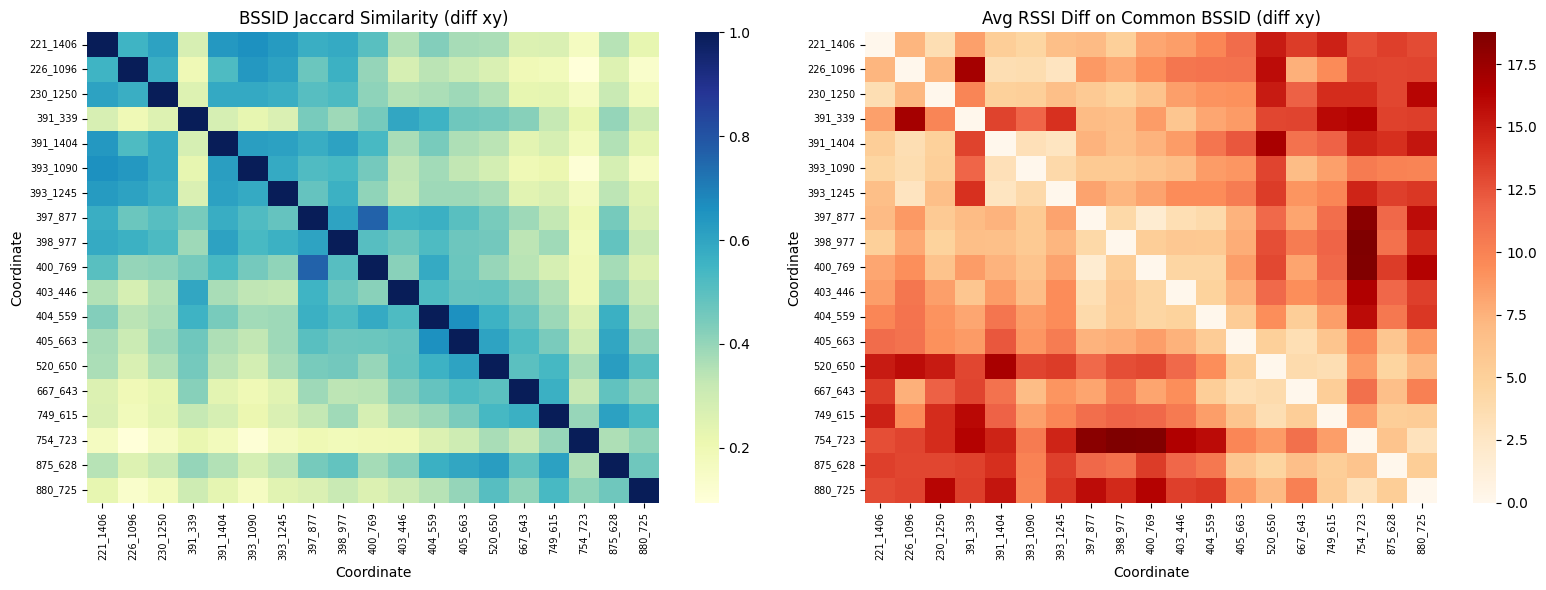

In [29]:
coord_labels = [f"{int(x)}_{int(y)}" for x, y in coords]
coord_index = {c: f"{int(c[0])}_{int(c[1])}" for c in coords}

jaccard_matrix = pd.DataFrame(index=coord_labels, columns=coord_labels, dtype=float)
for row in bssid_overlap_df.itertuples():
    c1 = coord_index[row.coord1]
    c2 = coord_index[row.coord2]
    jaccard_matrix.loc[c1, c2] = row.BSSID_jaccard
    jaccard_matrix.loc[c2, c1] = row.BSSID_jaccard

np.fill_diagonal(jaccard_matrix.values, 1.0)

rssi_diff_matrix = pd.DataFrame(index=coord_labels, columns=coord_labels, dtype=float)
for row in rssi_diff_df.itertuples():
    c1 = coord_index[row.coord1]
    c2 = coord_index[row.coord2]
    rssi_diff_matrix.loc[c1, c2] = row.avg_rssi_diff
    rssi_diff_matrix.loc[c2, c1] = row.avg_rssi_diff
np.fill_diagonal(rssi_diff_matrix.values, 0.0)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(jaccard_matrix, cmap='YlGnBu', ax=axes[0])
axes[0].set_title("BSSID Jaccard Similarity (diff xy)")
axes[0].set_xlabel("Coordinate")
axes[0].set_ylabel("Coordinate")
axes[0].tick_params(axis='x', labelsize=7) 
axes[0].tick_params(axis='y', labelsize=7)

sns.heatmap(rssi_diff_matrix, cmap='OrRd', ax=axes[1])
axes[1].set_title("Avg RSSI Diff on Common BSSID (diff xy)")
axes[1].set_xlabel("Coordinate")
axes[1].set_ylabel("Coordinate")
axes[1].tick_params(axis='x', labelsize=7) 
axes[1].tick_params(axis='y', labelsize=7)

plt.tight_layout()
plt.show()

In [123]:
local=pd.read_csv('2ndFloor_ver1_localization.csv')
gt=pd.read_csv('2ndFloor_ver1_groundtruth.csv')

local1=pd.read_csv('2ndFloor_ver2_localization.csv')
gt1=pd.read_csv('2ndFloor_ver2_groundtruth.csv')

local2=pd.read_csv('1stFloor_ver2_localization.csv')
gt2=pd.read_csv('1stFloor_ver2_groundtruth.csv')

In [124]:
result_analysis(local,gt,7,'2ndFloor_ver1_analysis.csv')
print("")
result_analysis(local1,gt1,7,'2ndFloor_ver2_analysis.csv')
print("")
result_analysis(local2,gt2,6,'1stFloor_ver2_analysis.csv')

--static points analysis--
  Point #         GT (x, y)  RMSE to GT  Mean Pairwise Distance
0       1  (404.00, 267.00)      69.509                  66.433
1       2  (486.00, 731.00)     161.153                 138.004
2       3  (611.00, 277.00)      45.748                  46.335
3       4  (717.00, 100.00)      59.371                  69.558
4       5  (752.00, 648.00)      27.194                  21.832
5       6  (728.00, 417.00)      73.704                  62.583
6       7   (477.00, 82.00)     177.105                 190.526
7     Avg                        87.683                  85.039


▶ Moving Part RMSE: 126.418

--static points analysis--
  Point #         GT (x, y)  RMSE to GT  Mean Pairwise Distance
0       1  (395.00, 272.00)      80.363                   8.052
1       2  (727.00, 654.00)      29.532                   5.223
2       3  (720.00, 155.00)      65.119                   3.625
3       4  (578.00, 268.00)      30.272                  34.547
4       5  (486.00,

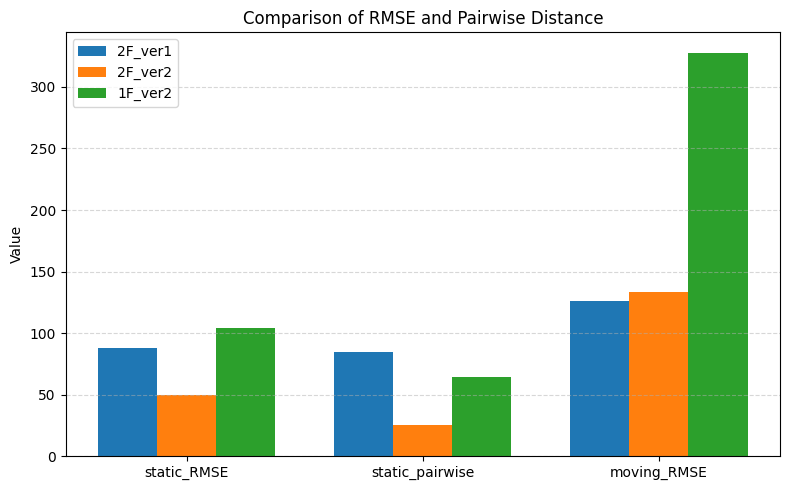

In [7]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['static_RMSE', 'static_pairwise', 'moving_RMSE']
data = {
    '2F_ver1': [88, 85, 126],
    '2F_ver2': [50, 25, 133],
    '1F_ver2': [104, 64, 328]
}

x = np.arange(len(labels)) 
width = 0.25 

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x - width, data['2F_ver1'], width, label='2F_ver1')
ax.bar(x, data['2F_ver2'], width, label='2F_ver2')
ax.bar(x + width, data['1F_ver2'], width, label='1F_ver2')

ax.set_ylabel('Value')
ax.set_title('Comparison of RMSE and Pairwise Distance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
# Max (x,y) of 1st floor = (1160,1540) : maximum distance (diagonal length) = 1930
# Max (x,y) of 2nd floor = (970,1540) : maximum distance (diagonal length) = 1820